In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/att-database-of-faces/README
/kaggle/input/att-database-of-faces/s32/3.pgm
/kaggle/input/att-database-of-faces/s32/1.pgm
/kaggle/input/att-database-of-faces/s32/9.pgm
/kaggle/input/att-database-of-faces/s32/8.pgm
/kaggle/input/att-database-of-faces/s32/6.pgm
/kaggle/input/att-database-of-faces/s32/7.pgm
/kaggle/input/att-database-of-faces/s32/2.pgm
/kaggle/input/att-database-of-faces/s32/10.pgm
/kaggle/input/att-database-of-faces/s32/4.pgm
/kaggle/input/att-database-of-faces/s32/5.pgm
/kaggle/input/att-database-of-faces/s39/3.pgm
/kaggle/input/att-database-of-faces/s39/1.pgm
/kaggle/input/att-database-of-faces/s39/9.pgm
/kaggle/input/att-database-of-faces/s39/8.pgm
/kaggle/input/att-database-of-faces/s39/6.pgm
/kaggle/input/att-database-of-faces/s39/7.pgm
/kaggle/input/att-database-of-faces/s39/2.pgm
/kaggle/input/att-database-of-faces/s39/10.pgm
/kaggle/input/att-database-of-faces/s39/4.pgm
/kaggle/input/att-database-of-faces/s39/5.pgm
/kaggle/input/att-database-of-faces

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

In [8]:
def load_orl_faces(dataset_path, img_size=(112,92)):
    data, labels = [], []
    for subject_dir in os.listdir(dataset_path):
        subject_path = os.path.join(dataset_path, subject_dir)
        if not os.path.isdir(subject_path):
            continue
        for img_file in os.listdir(subject_path):
            img_path = os.path.join(subject_path, img_file)
            img = Image.open(img_path).convert("L").resize(img_size)
            data.append(np.asarray(img, dtype=np.float32).flatten())
            labels.append(subject_dir)
    return np.array(data), np.array(labels)

In [6]:
def pca(X, k):
    # Standardize
    mean = np.mean(X, axis=0)
    X_centered = X - mean
    # Covariance trick: work in small space
    cov_small = np.dot(X_centered, X_centered.T)
    eigvals, eigvecs_small = np.linalg.eigh(cov_small)
    # Sort descending
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs_small = eigvecs_small[:, idx]
    # Map back to original space
    eigvecs = np.dot(X_centered.T, eigvecs_small)
    eigvecs = eigvecs / np.linalg.norm(eigvecs, axis=0)
    # Take top-k
    return mean, eigvecs[:, :k]

In [7]:
def project(X, mean, eigvecs):
    return np.dot(X - mean, eigvecs)

def reconstruct(W, mean, eigvecs):
    return np.dot(W, eigvecs.T) + mean

In [9]:
def nearest_neighbor(train_proj, train_labels, test_proj):
    preds = []
    for t in test_proj:
        dists = np.linalg.norm(train_proj - t, axis=1)
        preds.append(train_labels[np.argmin(dists)])
    return np.array(preds)

In [10]:
dataset_path = "/kaggle/input/att-database-of-faces"
X, y = load_orl_faces(dataset_path)
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
# PCA for recognition (try different k)
ks = [10, 20, 50, 100, 150]
accuracies = []

In [11]:
for k in ks:
    mean, eigvecs = pca(X_train, k)
    train_proj = project(X_train, mean, eigvecs)
    test_proj = project(X_test, mean, eigvecs)
    preds = nearest_neighbor(train_proj, y_train, test_proj)
    acc = accuracy_score(y_test, preds)
    accuracies.append(acc)
    print(f"k={k}, Accuracy={acc*100:.2f}%")

k=10, Accuracy=96.00%
k=20, Accuracy=98.00%
k=50, Accuracy=98.00%
k=100, Accuracy=98.00%
k=150, Accuracy=98.00%


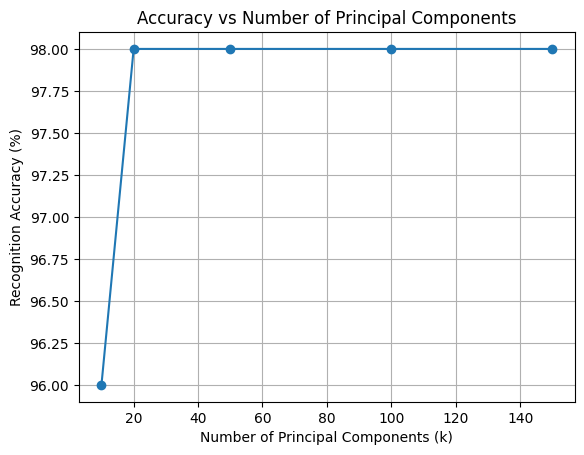

In [12]:
plt.figure()
plt.plot(ks, np.array(accuracies)*100, marker='o')
plt.xlabel("Number of Principal Components (k)")
plt.ylabel("Recognition Accuracy (%)")
plt.title("Accuracy vs Number of Principal Components")
plt.grid(True)
plt.show()

In [13]:
mean, eigvecs = pca(X_train, 50)
mean_face = mean.reshape(112,92)

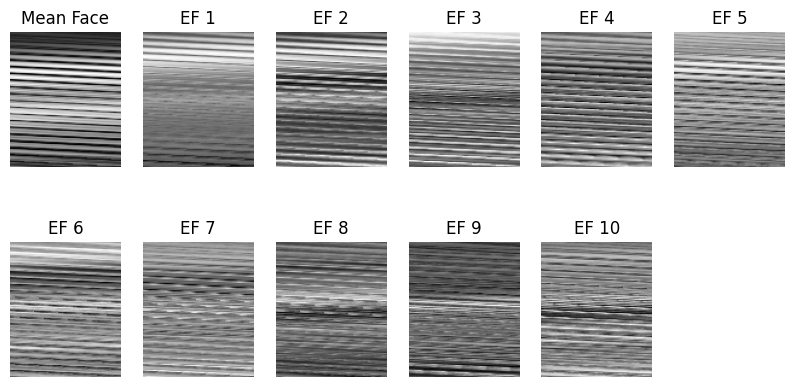

In [14]:
plt.figure(figsize=(10,5))
plt.subplot(2,6,1)
plt.imshow(mean_face, cmap='gray')
plt.title("Mean Face")
plt.axis('off')
for i in range(10):
    plt.subplot(2,6,i+2)
    plt.imshow(eigvecs[:,i].reshape(112,92), cmap='gray')
    plt.title(f"EF {i+1}")
    plt.axis('off')
plt.show()

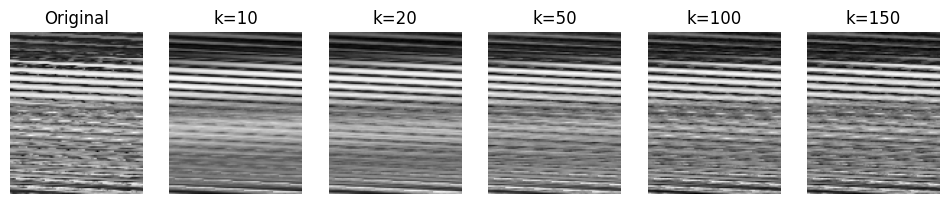

In [15]:
sample = X_test[0]
plt.figure(figsize=(12,3))
plt.subplot(1,len(ks)+1,1)
plt.imshow(sample.reshape(112,92), cmap='gray')
plt.title("Original")
plt.axis('off')
for i, k in enumerate(ks):
    mean, eigvecs = pca(X_train, k)
    W = project(sample.reshape(1,-1), mean, eigvecs)
    recon = reconstruct(W, mean, eigvecs)
    plt.subplot(1,len(ks)+1,i+2)
    plt.imshow(recon.reshape(112,92), cmap='gray')
    plt.title(f"k={k}")
    plt.axis('off')
plt.show()

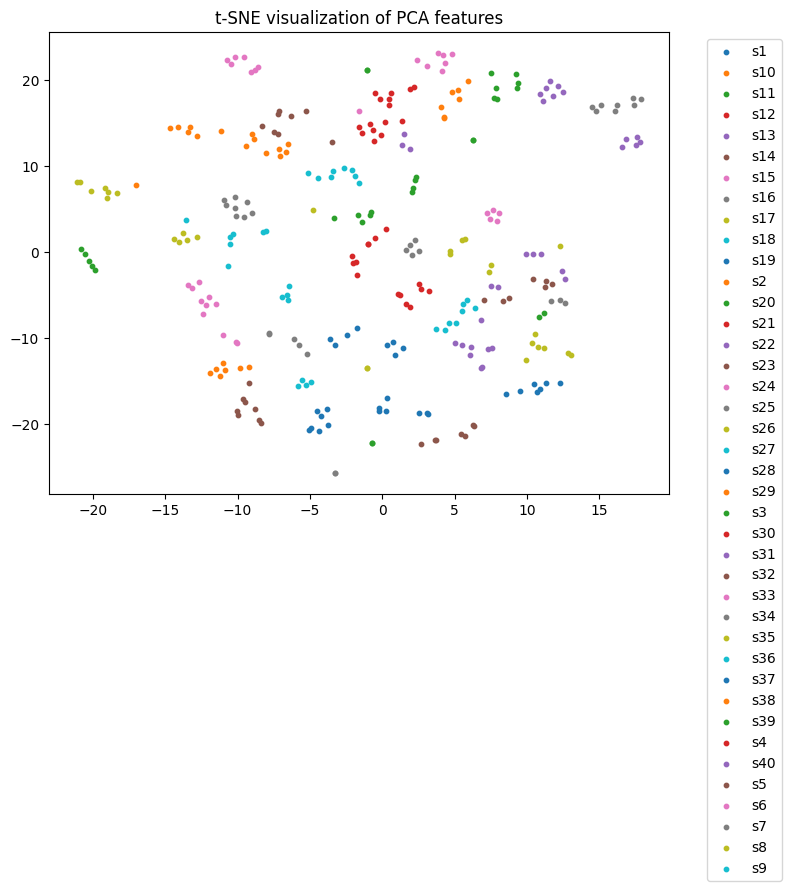

In [16]:
mean, eigvecs = pca(X_train, 50)
train_proj = project(X_train, mean, eigvecs)
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(train_proj)

plt.figure(figsize=(8,6))
for label in np.unique(y_train):
    idx = y_train == label
    plt.scatter(tsne_result[idx,0], tsne_result[idx,1], label=label, s=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE visualization of PCA features")
plt.show()